In [1]:
import pandas as pd
import numpy as np
from data_providers import YahooMarketDataProvider
from datetime import datetime
import tensorflow as tf
from agent import TradingAgent
from gym_trading_env.environments import TradingEnv
import gymnasium as gym
from tqdm import tqdm
import gym_trading_env
import mlflow
import warnings
import sys
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
data_provider = YahooMarketDataProvider()

In [5]:
data = data_provider.get_data('BTC-USD','1h', from_date='2022-01-01', to_date='2022-12-31')

In [6]:
len(data)

8695

In [7]:
#training episode to use weights of 
episode_checkpoint = 330
#initial starting capital
starting_capital = 10000                                                                                                
# max steps per episode
max_episode_steps=100
# total episodes
max_episodes = 100
# discount factor
gamma = .99
# update frequency between online model and target model
tau =100
# Adam learning rate
learning_rate=0.0001
 # L2 regularization using norm 2 euclidian distance
l2_reg = 1e-6
# size of the prioritized replay buffer
replay_capacity = int(1e5)
# batch size to fetch from replay buffer
batch_size=4096
# epsilon greedy policy parameters
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_episodes = 0.8* max_episodes
epsilon_exponential_decay = .99
actions = [-0.5-0.1,0,0.1,0.5]
def reward_function(history):
    return 800*np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) #log (p_t / p_t-1 )

number_of_features = 16
window_size = 15
state_dimensions = 95

checkpoint_file_path = "checkpoints/episode-{episode:04d}/checkpoint"

env = gym.make(
    "TradingEnv",
    name= "BTCUSD",
    df = data,
    windows= window_size,
    positions = actions,
    initial_position = 0, #Initial position
    trading_fees = 0.01/100, # 0.01% per stock buy / sell
    borrow_interest_rate= 0.0003/100, #per timestep (= 1h here)
    reward_function = reward_function,
    portfolio_initial_value = starting_capital, # in FIAT (here, USD)
    verbose=1,
)

num_actions=env.action_space.n

trading_agent = TradingAgent(
                num_actions=num_actions,
                learning_rate=learning_rate,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay_episodes=epsilon_decay_episodes,
                epsilon_exponential_decay=epsilon_exponential_decay,
                replay_capacity=replay_capacity,
                l2_reg=l2_reg,
                tau=tau,
                batch_size=batch_size,
                window_size=window_size,
                number_of_features=number_of_features,
                weights_path=checkpoint_file_path.format(episode=episode_checkpoint))

In [8]:
positions = []
close_prices = []

# Run an episode until it ends :
done, truncated = False, False
this_state = np.reshape(env.reset()[0],(window_size, number_of_features))
while not done and not truncated:
    action_index = trading_agent.predict(this_state)
    next_state, reward, done, truncated, info = env.step(action_index)
    next_state = np.reshape(next_state,(window_size, number_of_features))
    this_state = next_state
    positions.append(env.unwrapped.historical_info["position"][-1])
    close_prices.append(env.unwrapped.historical_info["data_date_close"][-1])



Market Return : -64.68%   |   Portfolio Return : -37.50%   |   


In [60]:
position_df = pd.DataFrame({'close': close_prices, 'position': positions})

In [61]:
sell_position_df = pd.DataFrame({"close": [None] * len(position_df)})
sell_filtered = position_df[position_df['position']<0]
sell_position_df.close[sell_filtered.index] = sell_filtered.close

buy_position_df = pd.DataFrame({"close": [None] * len(position_df)})
buy_filtered = position_df[position_df['position']>0]
buy_position_df.close[buy_filtered.index] = buy_filtered.close

In [62]:
import matplotlib.pyplot as plt

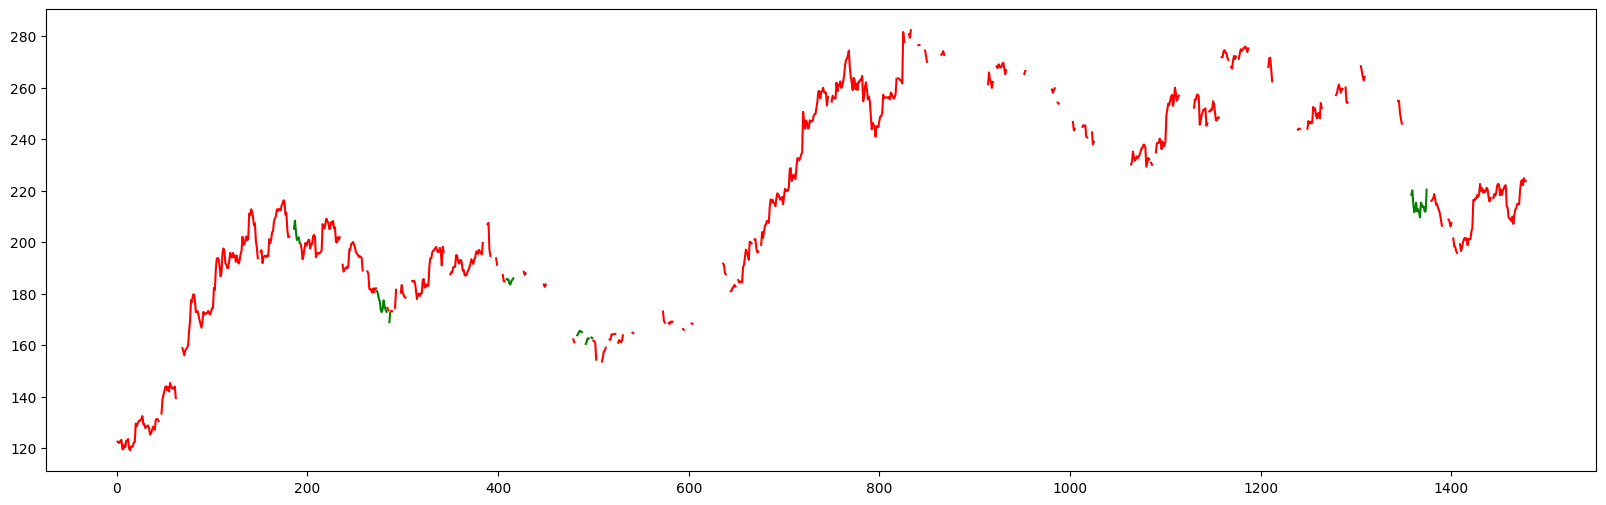

In [63]:

plt.figure(figsize=(20,6))
plt.plot(sell_position_df.close.tolist(), color='red')
plt.plot(buy_position_df.close.tolist(), color='green')
plt.show()